In [2]:
import EMGfiltersCONFIDENTIAL as EMGfilt
import h5py
import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import welch, iirnotch, filtfilt, butter, lfilter, iirfilter
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from pathlib import Path
import os
import matplotlib.tri as mtri
from scipy.interpolate import griddata
from matplotlib.path import Path
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter

In [3]:
def open_hdf5_file(file_path, dataset_name, mode='r'):
    hdf5_file = h5py.File(file_path, mode)
    if dataset_name in hdf5_file:
        dataset = hdf5_file[dataset_name]
    else:
        raise ValueError(f"Dataset '{dataset_name}' not found in the file.")
    return hdf5_file, dataset

In [4]:
#file_path = '/Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_17/PT_17_Day4/EMG_Calibration_day_4/Raw_emg_1.hdf5'
#file_path = '/Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_07/PT_07_Day1/EMG_Calibration_Day1/Raw_emg_1.hdf5'
file_path = '/Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_23/PT_23_Day1/EMG_Calibration/Raw_emg_1.hdf5'
dataset_name = 'rawEMG'
hdf5_file, dataset = open_hdf5_file(file_path, dataset_name, mode='r')
emg_data = np.array(dataset[:])
mvc_path = "/Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_23/PT_23_Day1/EMG_Calibration/Env_EMG_1.txt"

# try loading — assume whitespace or tab delimited
mvc_data = np.loadtxt(mvc_path)
print("MVC txt file shape:", mvc_data.shape)
print(mvc_data[:5, :5])  # peek at first few rows/cols

# order of EMG electrodes

order = [25,26,27,28,29,30,31,32,17,18,19,20,21,22,23,24,9,10,11,12,13,14,15,16,1,2,3,4,5,6,7,52,
8,49,50,51,40,39,38,37,36,35,34,33,48,47,46,45,42,43,41,56,47,55,54,53,62,63,64,60,61,57,58,59] #new_order
# order = [23,24,16,10,9,13,12,11,15,1,14,2,4,3,5,6,7,8,57,60,61,59,62,58,63,64,55,56,54,34,33,41,42,
#          43,44,53,22,21,20,19,18,17,25,26,27,28,29,30,40,32,38,36,31,39,37,35,47,46,45,49,48,52,51,50] #old_order
chanNumb = 64  # Number of channels for bipolar setup
fs = 2000  # sampling frequency
lowcut = 20
highcut = 500
envelopecut = 2
emg_filters = EMGfilt.EMGfilters(lowcut, highcut, envelopecut, fs, ch_numb=chanNumb)

MVC txt file shape: (750, 4)
[[1.19685183 1.39782101 1.24463059 1.33627717]
 [4.5355412  4.80438928 4.00945157 4.38833683]
 [6.25424139 6.28190276 4.93635381 5.48480344]
 [6.38791331 6.696324   5.08757214 5.55005406]
 [6.41662726 6.88425422 5.09812626 5.55731151]]


In [6]:
#emg_float would be a hdf5 file
emg_float = emg_data[:, 0:chanNumb].astype(float)
emg_cm = emg_filters.common_mean_filter(emg_float)
emg_hp = emg_filters.butter_highpass_filter(emg_cm)
emg_lp = emg_filters.butter_lowpass_filter(emg_hp)
emg_bs = emg_filters.butter_bandstop_filter(emg_lp)
emg_abs = np.abs(emg_bs)
emg_env = emg_filters.butter_lowpassEnv_filter(emg_abs)
order_zero_based = [i-1 for i in order]
emg_env = emg_env[:, order_zero_based]
win = 200
nwin = emg_env.shape[0] // win
env_win = emg_env[:nwin*win, :].reshape(nwin, win, emg_env.shape[1]).mean(axis=1)   # -> (nwin, 64)
print("env_win shape:", env_win.shape)  # ~ (746, 64) if your raw was 149200×64 (divided by 200)
amp_array = env_win.mean(axis=0)  
#amp_array = np.mean(emg_env, axis=0)

env_win shape: (750, 64)


In [7]:
flex_arr = np.mean(env_win[:,0:18],axis=1)
print(flex_arr[0:5])
#print(flex_arr)

[1.19685183 4.5355412  6.25424139 6.38791331 6.41662726]


In [9]:
print(mvc_data[:5, 0]) 


[ 8.60522121 29.25418074 41.4835576  41.88608407 44.24539485]


In [8]:
corr_arr = []
for i in range(64):
    channel_arr = env_win[:, i]
    if i < 18:
        corr_arr.append(scipy.stats.pearsonr(channel_arr, mvc_data[:, 0])[0])
    elif 17 < i < 36:
        corr_arr.append(scipy.stats.pearsonr(channel_arr, mvc_data[:, 1])[0])
    elif 35 < i < 48:
        corr_arr.append(scipy.stats.pearsonr(channel_arr, mvc_data[:, 2])[0])
    else:
        corr_arr.append(scipy.stats.pearsonr(channel_arr, mvc_data[:, 3])[0])

print(corr_arr)
   

[0.967294385912423, 0.9312453267669023, 0.9017441350982354, 0.958200399823397, 0.9345287108543208, 0.9881858852036556, 0.9904599327978231, 0.9666050708753456, 0.930354164376049, 0.9640582486747133, 0.8786317006127735, 0.9326744458138683, 0.9386854382825249, 0.9376464436486034, 0.9144342726820182, 0.8958330260237294, 0.8913410072513988, 0.9726970091549738, 0.8389344945536594, 0.8771206123637675, 0.9414055423206752, 0.85359076236704, 0.95204435392783, 0.8526439565853355, 0.9471885455466034, 0.9865231372912988, 0.9485815390665421, 0.9384507780464467, 0.8951175300262452, 0.8970945483270156, 0.885415950072324, 0.7694481787118668, 0.8264474523183083, 0.7383527945455532, 0.8157004665037195, 0.8249878225280163, 0.9904777701216008, 0.9826120013513143, 0.9838661746762725, 0.9947872417070447, 0.9769679244248697, 0.9966020324695433, 0.9842881471401048, 0.9862273718170824, 0.9919295966201533, 0.966981996237749, 0.985407968142231, 0.9770723048935128, 0.6427909649321244, 0.668776628320414, 0.70970140

In [9]:
coords = np.asarray([(22,4),(22,2),(22,0),(21,3),(21,1),(20,4),(20,2),(20,0),
                    (16.5,3),(16.5,1),(15.5,4),(15.5,2),(15.5,0),(14.5,3),(14.5,1),(13.5,4),(13.5,2),(13.5,0),
                    (8.5,4),(8.5,2),(8.5,0),(7.5,3),(7.5,1),(6.5,4),(6.5,2),(6.5,0),(5.5,3),(5.5,1),
                    (2,4),(2,2),(2,0),(1,3),(1,1),(0,4),(0,2),(0,0),
                    (17.5,19),(17.5,17),(16.5,20),(16.5,18),(16.5,16),(15.5,19),(15.5,17),(14.5,20),(14.5,18),(14.5,16),(13.5,19),(13.5,17),
                    (5.5,19),(4,20.5),(4,19),(4,17.5),(2.5,22),(2.5,20.5),(2.5,19),(1,20.5),
                    (-5,20),(-5,18),(-5,16),(-6,19),(-6,17),(-7,20),(-7,18),(-7,16)])   

values = corr_arr

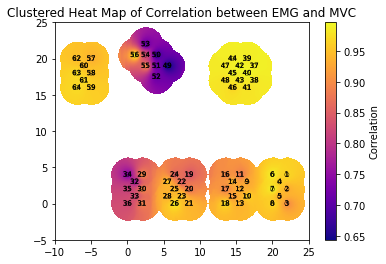

In [10]:
# inputs
xy = np.asarray(coords, float)       # (N, 2)
z  = np.asarray(values, float)       # (N,)

# ----- tunables -----
nx, ny       = 500, 500              # grid resolution
radius       = 2.5                   # influence radius for masking (device units)
k_neighbors  = 8                     # IDW: number of nearest points to blend
power        = 2.0                   # IDW power; higher = less smoothing
smooth_sigma = 0.8                   # optional post-blur of the raster (0 disables)
# ---------------------

# grid covering all sensors (expand a tad so circles are complete at edges)
pad = radius
xmin, ymin = xy.min(axis=0) - pad
xmax, ymax = xy.max(axis=0) + pad
gx, gy = np.meshgrid(np.linspace(xmin, xmax, nx),
                     np.linspace(ymin, ymax, ny))
grid_pts = np.c_[gx.ravel(), gy.ravel()]

# build k-d tree for neighbors and distance mask
tree = cKDTree(xy)

# IDW interpolation (extrapolates everywhere)
dists, idxs = tree.query(grid_pts, k=min(k_neighbors, len(xy)))
# Handle case k=1 -> shape (M,) to (M,1)
if dists.ndim == 1:
    dists = dists[:, None]
    idxs  = idxs[:, None]

# weights: 1 / d^p (avoid div by zero by snapping to exact value when d=0)
eps = 1e-12
w = 1.0 / np.maximum(dists, eps)**power
# if any exact hits, make them take full weight
exact = dists < 1e-12
if np.any(exact):
    w[exact] = 1.0
    # zero out other weights in those rows
    row_has_exact = exact.any(axis=1)
    w[row_has_exact] = exact[row_has_exact].astype(float)

vals_neighbors = z[idxs]                      # (M, k)
gz_flat = (w * vals_neighbors).sum(axis=1) / w.sum(axis=1)

# reshape to grid
gz = gz_flat.reshape(gx.shape)

# distance mask: keep only pixels within 'radius' of the nearest sensor
dmin, _ = tree.query(grid_pts, k=1)
mask_far = dmin.reshape(gx.shape) > radius
gz = np.ma.array(gz, mask=mask_far)

# optional smoothing INSIDE the mask
if smooth_sigma > 0:
    filled = np.where(gz.mask, np.nan, gz.filled(np.nan))
    # fill NaNs with local mean proxy before blur
    fill_val = np.nanmean(z)
    filled = np.where(np.isnan(filled), fill_val, filled)
    filled = gaussian_filter(filled, sigma=smooth_sigma)
    gz = np.ma.array(filled, mask=mask_far)

# new labels (reordered space): 1..64
labels_new = np.arange(1, 65)

# original labels that produced each new column (from your 'order' list)
labels_orig = np.array(order)  # 1..64, original numbering

# plot
plt.figure()
plt.xlim(-10,25)
plt.ylim(-5, 25)
im = plt.imshow(gz, origin='lower',
                extent=[xmin, xmax, ymin, ymax],
                cmap='plasma', aspect='equal')
plt.scatter(xy[:,0], xy[:,1], c=z, cmap='plasma',
            edgecolor='k', linewidth=0.4, s=18)
for i, (x, y) in enumerate(xy):
    # choose ONE of these texts:
    txt = f"{labels_new[i]}" 
    plt.text(
        x, y, txt,
        ha="center", va="center", fontsize=7, color="black",
        path_effects=[pe.withStroke(linewidth=.1)] #, foreground="black")]
    )
plt.colorbar(im, label='Correlation')
plt.title('Clustered Heat Map of Correlation between EMG and MVC')
plt.show()


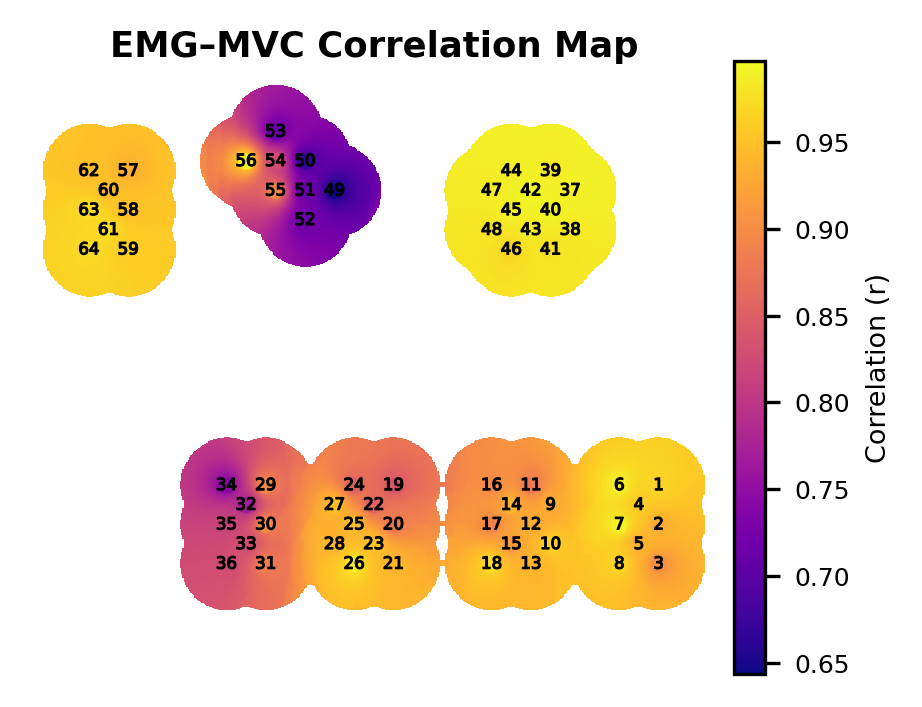

In [11]:
# --- Compact high-quality EMG–MVC correlation plot ---
plt.figure(figsize=(3, 3), dpi=300)  # smaller but still high-res

# Heatmap background (IDW grid)
im = plt.imshow(
    gz, origin='lower',
    extent=[xmin, xmax, ymin, ymax],
    cmap='plasma', aspect='equal',
    interpolation='gaussian'  # smooth color transitions
)

# Sensor points
plt.scatter(
    xy[:, 0], xy[:, 1],
    c=z, cmap='plasma',
    edgecolor='black', linewidth=0.0,
    s=15, antialiased=True, zorder=3
)

# Channel labels (new numbering 1–64)
for i, (x, y) in enumerate(xy):
    txt = f"{labels_new[i]}"
    plt.text(
        x, y, txt,
        ha="center", va="center",
        fontsize=4, color="black",
        path_effects=[pe.withStroke(linewidth=0.3)],
        zorder=4
    )

# Axis limits and layout
plt.xlim(-10, 25)
plt.ylim(-5, 25)
plt.axis("off")  # cleaner look for small figure
plt.title("EMG–MVC Correlation Map", fontsize=8.5, weight="bold", pad=4)

# Compact colorbar
cbar = plt.colorbar(im, label="r", shrink=0.7, pad=0.02)
cbar.ax.tick_params(labelsize=6)
cbar.set_label("Correlation (r)", fontsize=6.5)

plt.tight_layout(pad=0.3)
#plt.savefig("EMG_MVC_heatmap_PT07_Day2_small.png",
#            dpi=600, bbox_inches="tight", transparent=True)
plt.show()


In [13]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter
import scipy.stats as stats

# ---------------- CONFIG ----------------
baseDir = Path("/Volumes/LaCie/ResearchProjects/Null_Space_EMG")
outDir  = baseDir / "preprocessing" / "EMG_MVC_subj_plots"
outDir.mkdir(parents=True, exist_ok=True)

#subs  = ['16', '17', '18', '19', '20', '21'] #['07','08', '09', '10', '11', '12', '13', '14', '15']                        # subject to run
subs = ['23']
days = ['1']
#days = ["1","2","3","4","5"]        # Day1..Day5

dataset_name = "rawEMG"
fs = 2000
lowcut = 20
highcut = 500
envelopecut = 2
chanNumb = 64
win = 200                           # downsample window (200 samples)

# === Your canonical channel order for DATA (1-based) ===

# desired_order = [
#     23,24,16,10,9,13,12,11,15,1,14,2,4,3,5,6,7,8,                         # flexors (18)
#     57,60,61,59,62,58,63,64,55,56,54,34,33,41,42,43,44,53,                # extensors (18)
#     22,21,20,19,18,17,25,26,27,28,29,30,                                   # biceps (12)
#     40,32,38,36,31,39,37,35,                                               # lateral tri (8)
#     47,46,45,49,48,52,51,50                                                # long tri (8)
# ] #old order pt7-15
desired_order = [25,26,27,28,29,30,31,32,17,18,19,20,21,22,23,
                24,9,10,11,12,13,14,15,16,1,2,3,4,5,6,7,52,
                8,49,50,51,40,39,38,37,36,35,34,33,48,47,46,45,
                42,43,41,56,47,55,54,53,62,63,64,60,61,57,58,59] #new_order

reorder_idx0 = np.array([i-1 for i in desired_order])  # DATA reindex

# Map between new (reordered) labels and original labels
new_to_old = dict(zip(range(1,65), desired_order))         # new label -> original label
old_to_new = {v: k for k, v in new_to_old.items()}         # original -> new

# Sensor coordinates in ORIGINAL order (do NOT reorder)
coords = np.asarray([
    (22,4),(22,2),(22,0),(21,3),(21,1),(20,4),(20,2),(20,0),
    (16.5,3),(16.5,1),(15.5,4),(15.5,2),(15.5,0),(14.5,3),(14.5,1),(13.5,4),(13.5,2),(13.5,0),
    (8.5,4),(8.5,2),(8.5,0),(7.5,3),(7.5,1),(6.5,4),(6.5,2),(6.5,0),(5.5,3),(5.5,1),
    (2,4),(2,2),(2,0),(1,3),(1,1),(0,4),(0,2),(0,0),
    (17.5,19),(17.5,17),(16.5,20),(16.5,18),(16.5,16),(15.5,19),(15.5,17),(14.5,20),(14.5,18),(14.5,16),(13.5,19),(13.5,17),
    (5.5,19),(4,20.5),(4,19),(4,17.5),(2.5,22),(2.5,20.5),(2.5,19),(1,20.5),
    (-5,20),(-5,18),(-5,16),(-6,19),(-6,17),(-7,20),(-7,18),(-7,16)
], float)

# IDW / grid params
nx, ny       = 500, 500
radius       = 2.5
k_neighbors  = 8
power        = 2.0
smooth_sigma = 0.8

# Precompute grid (coords unchanged)
pad = radius
xmin, ymin = coords.min(axis=0) - pad
xmax, ymax = coords.max(axis=0) + pad
gx, gy = np.meshgrid(np.linspace(xmin, xmax, nx),
                     np.linspace(ymin, ymax, ny))
grid_pts = np.c_[gx.ravel(), gy.ravel()]
tree = cKDTree(coords)

# Collect per-day panels
for sub in subs:
    day_panels = []

    for day in days:
        # find EMG_Calibration via wildcard session dir
        dayDir = baseDir / f"PT_{sub}" / f"PT_{sub}_Day{day}"
        calib_dirs = [p for p in dayDir.glob("*/EMG_Calibration") if p.is_dir()]
        if not calib_dirs:
            print(f"⚠️  No EMG_Calibration under {dayDir}")
            continue

        calib_dir = sorted(calib_dirs)[0]
        emg_path = calib_dir / "Raw_emg_1.hdf5"
        mvc_path = calib_dir / "Env_EMG_1.txt"

        if not emg_path.exists() or not mvc_path.exists():
            print(f"⚠️  Missing EMG/MVC in {calib_dir}, skipping Day {day}")
            continue

        # --- Load EMG ---
        try:
            h5, dset = open_hdf5_file(str(emg_path), dataset_name, mode='r')
            emg_data = np.array(dset[:])  # (time, 64)
            h5.close()
        except Exception as e:
            print(f"⚠️  Could not open {emg_path.name}: {e}")
            continue
        if emg_data.ndim != 2 or emg_data.shape[1] != 64:
            print(f"⚠️  Unexpected EMG shape {emg_data.shape} in {emg_path.name}. Skipping.")
            continue

        # --- Load MVC (4 columns) ---
        try:
            mvc_data = np.loadtxt(str(mvc_path))
        except Exception as e:
            print(f"⚠️  Could not load {mvc_path.name}: {e}")
            continue

        # --- Filters / rect / envelope ---
        emg_filters = EMGfilt.EMGfilters(lowcut, highcut, envelopecut, fs, ch_numb=chanNumb)
        emg_float = emg_data[:, :chanNumb].astype(float)
        emg_cm = emg_filters.common_mean_filter(emg_float)
        emg_hp = emg_filters.butter_highpass_filter(emg_cm)
        emg_lp = emg_filters.butter_lowpass_filter(emg_hp)
        emg_bs = emg_filters.butter_bandstop_filter(emg_lp)
        emg_abs = np.abs(emg_bs)
        emg_env = emg_filters.butter_lowpassEnv_filter(emg_abs)

        # >>> REORDER DATA ONLY <<<
        emg_env_reordered = emg_env[:, reorder_idx0]             # (time, 64) in canonical order

        # Downsample envelope every 200 samples
        nwin = emg_env_reordered.shape[0] // win
        env_win = emg_env_reordered[:nwin*win, :].reshape(nwin, win, chanNumb).mean(axis=1)  # (nwin, 64)

        # Align rows with MVC
        nrows = min(env_win.shape[0], mvc_data.shape[0])
        env_win = env_win[:nrows, :]
        mvc_trim = mvc_data[:nrows, :]  # (nrows, 4)

        # Correlate per channel (in REORDERED space)
        corr_reordered = np.empty(64, dtype=float)
        for i in range(64):
            ch = env_win[:, i]
            if i < 18:
                corr_reordered[i] = stats.pearsonr(ch, mvc_trim[:, 0])[0]
            elif i < 36:
                corr_reordered[i] = stats.pearsonr(ch, mvc_trim[:, 1])[0]
            elif i < 48:
                corr_reordered[i] = stats.pearsonr(ch, mvc_trim[:, 2])[0]
            else:
                corr_reordered[i] = stats.pearsonr(ch, mvc_trim[:, 3])[0]

        # <<< MAP BACK to ORIGINAL channel order for plotting with ORIGINAL coords >>>
        z_orig = np.empty(64, dtype=float)
        # new label 1..64 -> original label (from desired_order)
        for new_label in range(1, 65):
            orig_label = new_to_old[new_label]     # original electrode number
            z_orig[orig_label - 1] = corr_reordered[new_label - 1]

        # --- IDW grid over ORIGINAL coords ---
        dists, idxs = tree.query(grid_pts, k=min(k_neighbors, len(coords)))
        if dists.ndim == 1:
            dists = dists[:, None]
            idxs  = idxs[:, None]

        eps = 1e-12
        w = 1.0 / np.maximum(dists, eps)**power
        exact = dists < 1e-12
        if np.any(exact):
            w[exact] = 1.0
            row_has_exact = exact.any(axis=1)
            w[row_has_exact] = exact[row_has_exact].astype(float)

        vals_neighbors = z_orig[idxs]
        gz_flat = (w * vals_neighbors).sum(axis=1) / w.sum(axis=1)
        gz = gz_flat.reshape(gx.shape)

        dmin, _ = tree.query(grid_pts, k=1)
        mask_far = dmin.reshape(gx.shape) > radius
        gz = np.ma.array(gz, mask=mask_far)

        if smooth_sigma > 0:
            filled = np.where(gz.mask, np.nan, gz.filled(np.nan))
            fill_val = np.nanmean(z_orig)
            filled = np.where(np.isnan(filled), fill_val, filled)
            filled = gaussian_filter(filled, sigma=smooth_sigma)
            gz = np.ma.array(filled, mask=mask_far)

        day_panels.append({"day": day, "gz": gz, "z": z_orig, "xy": coords})

    # --------- PANEL FIGURE (1×N) ---------
    if not day_panels:
        print("No panels to plot.")
    else:
        n = len(day_panels)
        fig, axes = plt.subplots(1, n, figsize=(3*n, 3), dpi=300, constrained_layout=True,
                                facecolor="white")  # white background
        if n == 1:
            axes = [axes]

        # consistent color range across all days
        all_vals = np.concatenate([p["z"] for p in day_panels])
        vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)

        for i, (ax, panel) in enumerate(zip(axes, day_panels)):
            gz = panel["gz"]; z = panel["z"]; xy = panel["xy"]

            im = ax.imshow(
                gz, origin='lower',
                extent=[xmin, xmax, ymin, ymax],
                cmap='plasma', aspect='equal',
                interpolation='gaussian', vmin=vmin, vmax=vmax
            )
            ax.scatter(
                xy[:, 0], xy[:, 1], c=z, cmap='plasma', vmin=vmin, vmax=vmax,
                edgecolor='black', linewidth=0.0, s=15, antialiased=True, zorder=3
            )

            # label channels (original 1–64)
            for j, (x, y) in enumerate(xy):
                ax.text(
                    x, y, f"{j+1}",
                    ha="center", va="center",
                    fontsize=5.0, color="black",
                    path_effects=[pe.withStroke(linewidth=0.4)],
                    zorder=4
                )

            # add a thin vertical divider between panels except after last
            if i < n - 1:
                ax.axvline(xmax + 2, color='gray', linewidth=0.6, alpha=0.5, zorder=10)

            ax.set_title(f"Day {panel['day']}", fontsize=9, weight="bold", pad=6)
            ax.set_axis_off()
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            ax.set_facecolor("white")

        # colorbar (shared)
        cbar = fig.colorbar(im, ax=axes, shrink=0.85, pad=0.02)
        cbar.ax.tick_params(labelsize=7)
        cbar.set_label("Correlation (r)", fontsize=7.5)

        # ---- figure title ----
        fig.suptitle(f"PT_{sub}_EMG_MVC_days", fontsize=10, weight="bold", y=1.02)

        # save + show
        save_path = outDir / f"PT_{sub}_EMG_MVC_days.png"
        fig.savefig(save_path, dpi=600, bbox_inches="tight", facecolor="white")
        print(f"✅ Saved panel → {save_path}")

        plt.show()


⚠️  No EMG_Calibration under /Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_23/PT_23_Day1
No panels to plot.
